# ASSIGNMENT 20 : FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

#### Part 1: Data Preparation and Exploration

In [49]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

#### 1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [4]:
df = pd.read_csv(r"F:\Data science Course by ExcelR\ASSIGNMENTS\20. Timeseries\exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [6]:
df.shape

(7588, 2)

7588 rows and 2 columns

In [9]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

We have only 2 columns.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


We can see date is in object format (inconsistent) let's convert it to date so we can set it as index for further process.

In [15]:
# let's convert date from object to datetime format
df['date'] = df['date'].apply(lambda x: x.split(" ")[0])     #retaining only date (still in objec) 
df['date'] = pd.to_datetime(df['date'], dayfirst=True)       # object to datetime format (only date)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


#### 2. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.


In [20]:
#Let's set the date as index for plotting 
df.set_index('date', inplace=True)

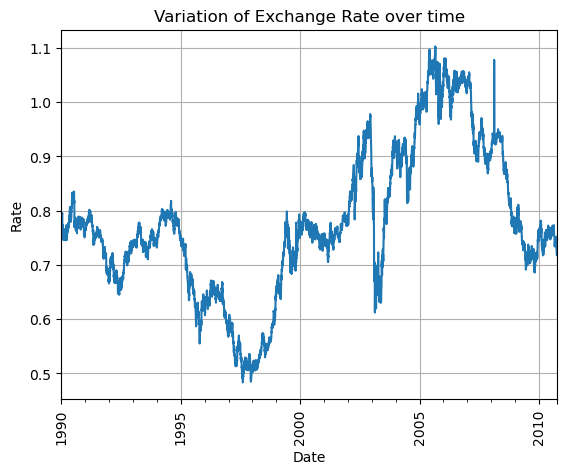

In [22]:
# Plotting time series for currency 
df['Ex_rate'].plot()
plt.title("Variation of Exchange Rate over time")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.xticks(rotation=90)
plt.grid()
plt.show()

* We can see that there is a lot of noise in the dataset.
* We can also see there is no proper trend, seasonality.
* We can see few nomalies around 2002 a sudden drop in exchange rate.
* Similarly 2008 has sudden spike increase in the exchange rate.

#### 3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [26]:
df.isnull().sum()

Ex_rate    0
dtype: int64

* No missing values so we can go further

#### Part 2: Model Building - ARIMA

#### 1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series


To Implement ARIMA model our dataset needs to be stationary

In [31]:
# A function to perform ADFULLER TEST

from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    #performing adfuller test 
    dftest=adfuller(dataset, autolag='AIC')

    #Printing the result
    print("1. ADF :",dftest[0])
    print("2. P-value:",dftest[1])
    print("3. Num of Lags",dftest[2])
    print("4. Num of Observation used for ADF Regression and Critical Values Calculation:",dftest[3])
    print("5. Critical values:")
    for key, val in dftest[4].items():
        print("\t",key,":",val)

In [33]:
ad_test(df['Ex_rate'])

1. ADF : -1.6649941807381343
2. P-value: 0.44923273535979974
3. Num of Lags 1
4. Num of Observation used for ADF Regression and Critical Values Calculation: 7586
5. Critical values:
	 1% : -3.4312123140180137
	 5% : -2.861921078147796
	 10% : -2.5669728434336108


* We can see the series is not stationary at all we need to perform first difference to make it stable.
* p value greater than 0.05 and ADF close to 0 suggest the series is not stationary

In [36]:
# Performing first difference to get stationary series 
diff_rate = df['Ex_rate'].diff()                       # perform first difference
diff_rate.dropna(inplace=True)                         #removing the first row since it contains null value

In [38]:
ad_test(diff_rate)

1. ADF : -99.39343120118627
2. P-value: 0.0
3. Num of Lags 0
4. Num of Observation used for ADF Regression and Critical Values Calculation: 7586
5. Critical values:
	 1% : -3.4312123140180137
	 5% : -2.861921078147796
	 10% : -2.5669728434336108


* Now our series is stable.
* Now we can plot ACF and PACF to help identify initial values for p, d and q

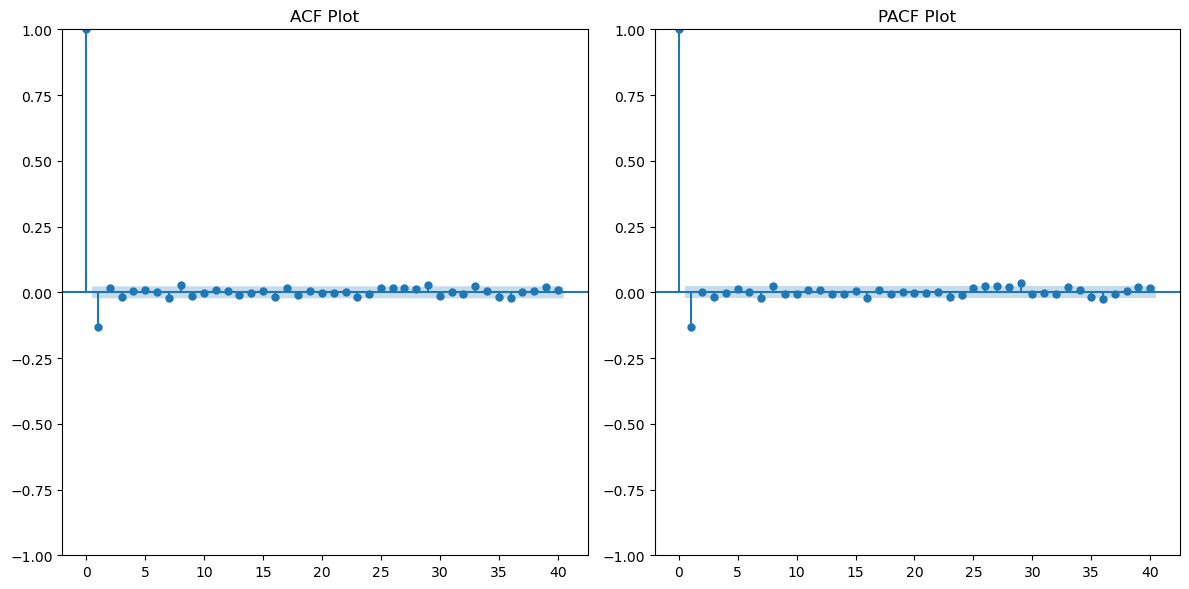

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (12, 6))

#plotting acf plot
plt.subplot(1, 2, 1)
plot_acf(diff_rate, lags=40, ax=plt.gca())
plt.title("ACF Plot")

#plot pacf
plt.subplot(1, 2, 2)
plot_pacf(diff_rate, lags=40, ax=plt.gca())
plt.title("PACF Plot")

plt.tight_layout()
plt.show()

* From above plots we can choose, p=1 and q = 1
* d = 1 since the data became stationary after just first difference

#### 2. Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [45]:
# splitting the data for training and testing

train = df.iloc[:-30]
test = df.iloc[-30:]

train.shape, test.shape

((7558, 1), (30, 1))

In [51]:
from statsmodels.tsa.arima.model import ARIMA

#fitting the ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))    #(order = (p=1,d=1,q=1))
arima_model_res = arima_model.fit()

#Display the summary of the fitted model
print(arima_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7558
Model:                 ARIMA(1, 1, 1)   Log Likelihood               27934.471
Date:                Fri, 31 Jan 2025   AIC                         -55862.942
Time:                        03:55:36   BIC                         -55842.152
Sample:                    01-01-1990   HQIC                        -55855.806
                         - 09-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1262      0.045     -2.783      0.005      -0.215      -0.037
ma.L1         -0.0056      0.045     -0.123      0.902      -0.095       0.083
sigma2      3.604e-05   9.99e-08    360.764      0.0

#### 3. Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

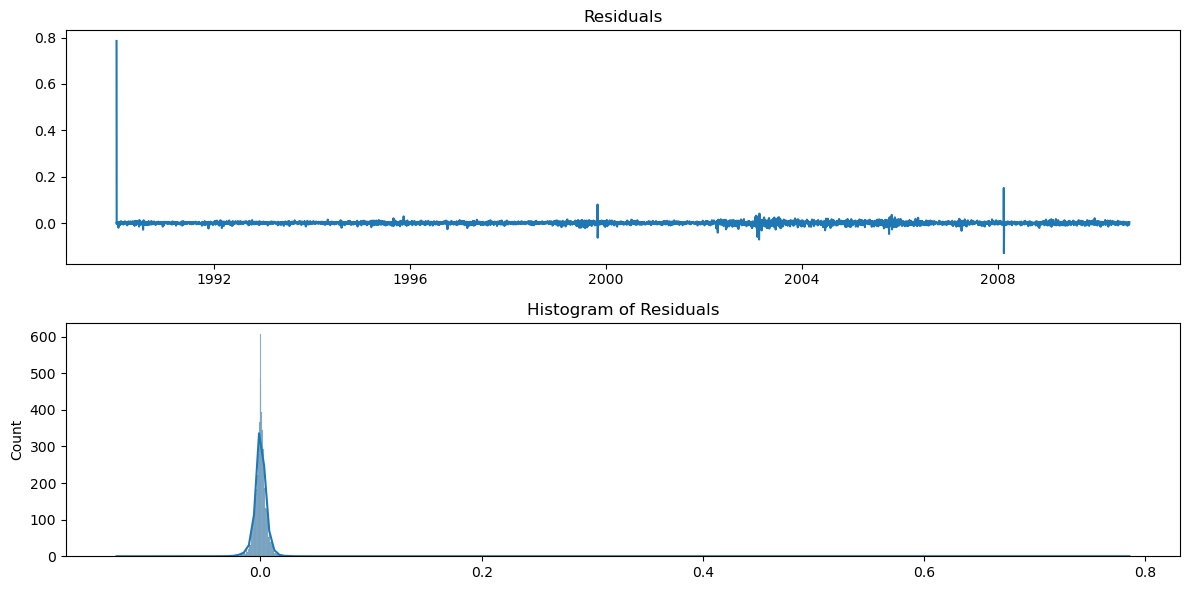

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#plot residuals
residuals = arima_model_res.resid
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title("Residuals")

plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

In [56]:
# Perform Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags = [10], return_df=True)
print("Ljung-Box Test Results :\n", lb_test)
print()

#perform adfuller test
# model = ad_test(residuals)
ad_test(residuals)

Ljung-Box Test Results :
      lb_stat  lb_pvalue
10  1.804455   0.997631

1. ADF : -157.57980266453853
2. P-value: 0.0
3. Num of Lags 0
4. Num of Observation used for ADF Regression and Critical Values Calculation: 7557
5. Critical values:
	 1% : -3.4312156242745453
	 5% : -2.861922540819951
	 10% : -2.5669736220336574


* From above plots and results we can say:
* Residual plot has no discernible patterns
* Histogram Residual is resembling normal distribution
* Ljung-Box test : p_value(0.306319) > 0.05 suggests no significant autocorrelation in the residuals.

Therefore we can say that the model has no apparnt inadequacies.

#### 4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

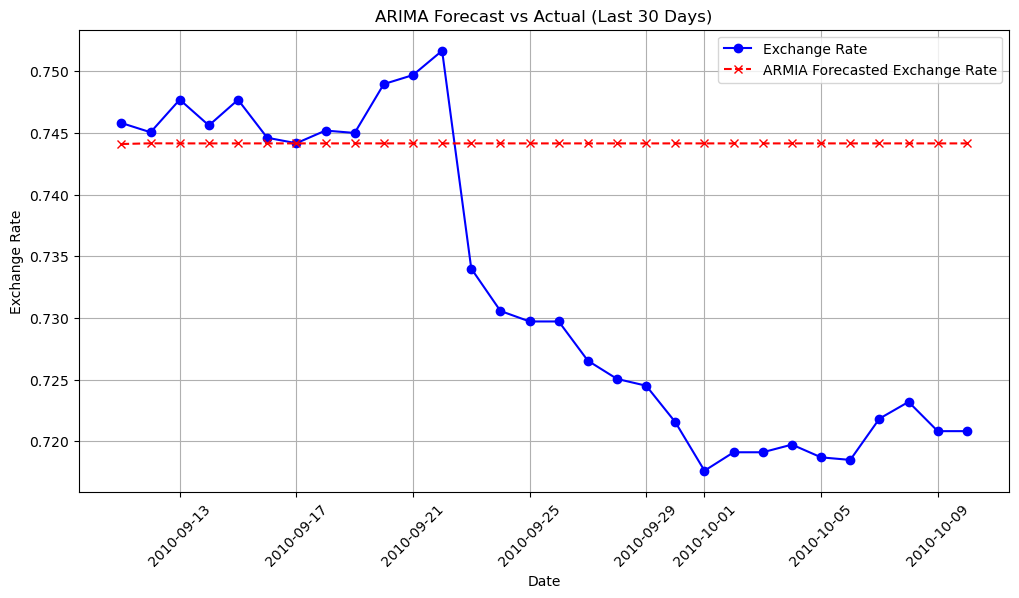

In [84]:
# Forecast the last 30 days of the dataset

#predictng the values from the above built model
arima_forecasted = arima_model_res.forecast(30)

# Plot only the last 30 days
plt.figure(figsize=(12, 6))
plt.plot(test, label="Exchange Rate", color='blue', marker='o')
plt.plot(arima_forecasted, label="ARMIA Forecasted Exchange Rate", linestyle='dashed', color='red', marker='x')
plt.title("ARIMA Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(arima_forecasted, test))
print(rmse)

0.016632177912475444


#### Part 3: Model Building - Exponential Smoothing
#### 1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).


* Based on the above results we can say that our model has no trend or seasonality so we'll be going ahead with Exponential Smoothing Model.

In [90]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

#Model Building 
smooth_model = SimpleExpSmoothing(train)
smooth_model = smooth_model.fit(smoothing_level=0.2, optimized=True)

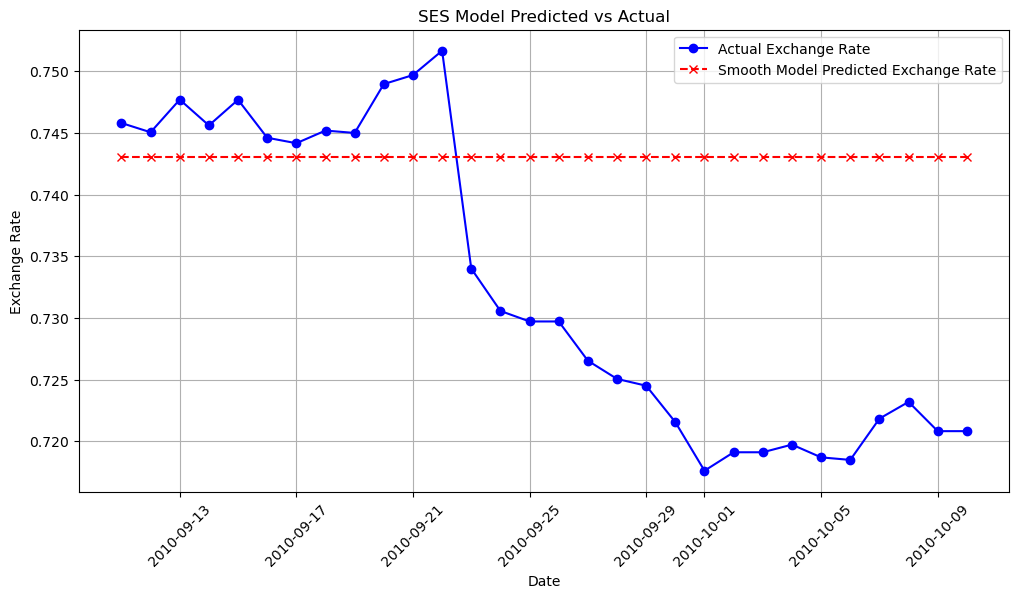

In [92]:
# Forecast the last 30 days of the dataset

#Getting the forecasted values
forecasted_smooth = smooth_model.forecast(30)

# Plot only the last 30 days
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual Exchange Rate", color='blue', marker='o')
plt.plot(forecasted_smooth, label="Smooth Model Predicted Exchange Rate", linestyle='dashed', color='red', marker='x')
plt.title("SES Model Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

#### 2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

In [95]:
# Finding the best parameters using AIC technique.

# Define a range of smoothing levels to test
alpha_values = np.linspace(0.01, 1, 50)          # 50 values between 0.01 and 1

# Dictionary to store AIC values
aic_scores = {}

# Grid search for optimal smoothing level
for alpha in alpha_values:
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    aic_scores[alpha] = model.aic

# Find the best alpha with minimum AIC
best_alpha = min(aic_scores, key=aic_scores.get)
best_aic = aic_scores[best_alpha]

best_alpha, best_aic

(0.8787755102040816, -77319.80825661504)

#### 3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

In [98]:
#Fitting model with best parameters

best_model = SimpleExpSmoothing(train)
best_model = best_model.fit(smoothing_level=best_alpha, optimized=False)

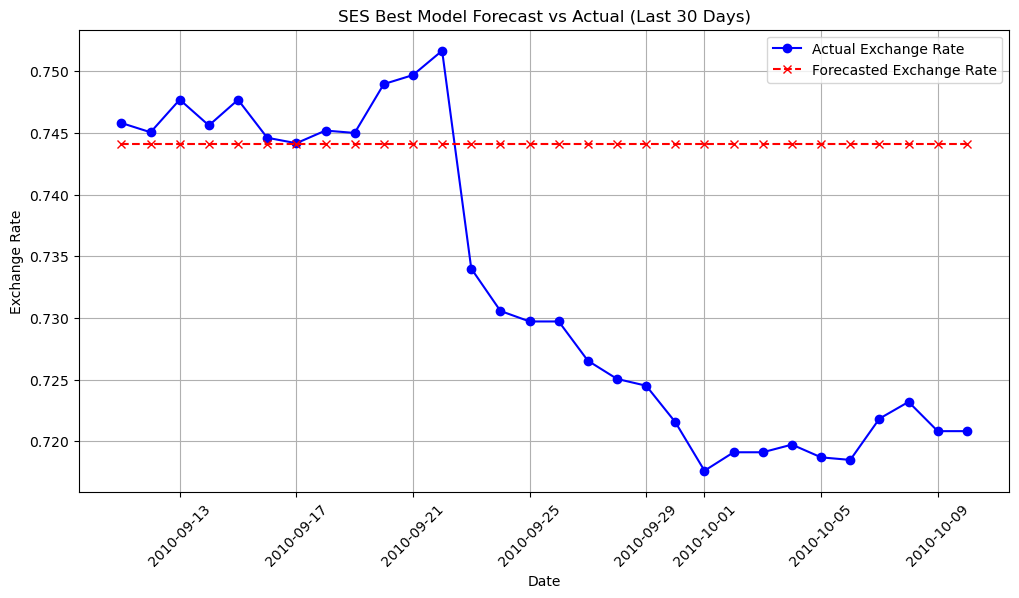

In [118]:
# Forecast the last 30 days of the dataset

# Getting the forcasted values
best_forecasted = best_model.forecast(30)

# Plot only the last 30 days
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual Exchange Rate", color='blue', marker='o')
plt.plot(best_forecasted, label="Forecasted Exchange Rate", linestyle='dashed', color='red', marker='x')
plt.title("SES Best Model Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

#### Part 4: Evaluation and Comparison
#### 1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models. (i.e ARIMA and Exponential Smoothening Model)
#### 2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
#### 3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

In [121]:
# function to compute errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
def compute_errors(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    return mae, rmse, mape

In [123]:
# Let's compute the metrics of ARIMA Model
mae1, rmse1, mape1 = compute_errors(np.array(arima_forecasted), np.array(test))
print("---ARIMA MODEL---")
print("Mean Absolute Error :", mae1)
print("Root Mean Square Error :", rmse1)
print("Mean Absolute Percentage Error :", mape1)

---ARIMA MODEL---
Mean Absolute Error : 0.013494600805702773
Root Mean Square Error : 0.016632177912475444
Mean Absolute Percentage Error : 1.8132007198628202


In [125]:
# Let's compute the metrics of ARIMA Model
mae2, rmse2, mape2 = compute_errors(best_forecasted.values, test.values)
print("---Best Exponential Smoothing Model---")
print("Mean Absolute Error :", mae2)
print("Root Mean Square Error :", rmse2)
print("Mean Absolute Percentage Error :", mape2)

---Best Exponential Smoothing Model---
Mean Absolute Error : 0.013486094769555068
Root Mean Square Error : 0.016608011143195846
Mean Absolute Percentage Error : 1.8123812805513204


* From above we can infer that both models are performing almost the same but Exponential Smoothing Model is slightly better than ARIMA model.

**Comparison of ARIMA and SES**
1. Performance:
   * Arima Performs well if the data has patterns, trends or seasonality. In this case it is permerming slightly lerrer since there is no trends or seasonality in the dataset
   * SES performs best for stationary data. In this case the data is stationary so it permorms better
2. Accuracy (For this use case):
   * Arima has slightly less MAPA score (1.8132007198628202)
   * SES performs slightly better MAPA Score (1.8123812805513204)
3. Adaptability:
   * ARIMA can capture trens and autocorrelation but needs fine tuning (In this case p=1,d=1,q=1)
   * SES reacts quickly for short term changes
4. Complexity:
   * Arima is more
   * SES lesser comparatively
5. Forecasting Capabilities:
   * Arima is best for medium to long term
   * SES is best for short term forecasting

**Model Comparison**

| **Model** | **MAE** | **RMSE** | **MAPE** | **Best for** |
|-----------|---------------|---------------|---------------|-------------------------------|
| **SES (Simple Exponential Smoothing)** |   Lower if data is stationary |   Lower for stable data |   Lower if no trend | Short-term forecasts |
| **ARIMA (Best (p,d,q) chosen)** |   Lower if data has patterns |   Lower if trends exist |   Lower for non-stationary data | Long-term + trend-based forecasting |

**In Conclusion**

* **SES is better for exchange rate forecasting because**.  
* * **data is stationary** (no trend/seasonality).  
* * **short-term forecasting** and yields a **reactive models**.

- In our case the performance of ARIMA and SES was almost similar so we should go with SES model since it is faster and less complex